In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [2]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

In [3]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(MemoryCollection)

# Invoke the model to produce structured output that matches the schema
memory_collection = model_with_structure.invoke([HumanMessage("My name is Lance. I like to bike.")])
memory_collection.memories

[Memory(content="User's name is Lance."),
 Memory(content='User enjoys biking.')]

In [4]:
memory_collection.memories[0].model_dump()


{'content': "User's name is Lance."}

In [5]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memories")

# Save a memory to namespace as key and value
key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = memory_collection.memories[1].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

In [6]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memories'], 'key': '7dd04cc5-5935-4b2e-9d96-4aba79dc3252', 'value': {'content': "User's name is Lance."}, 'created_at': '2025-03-19T16:20:12.564043+00:00', 'updated_at': '2025-03-19T16:20:12.564043+00:00', 'score': None}
{'namespace': ['1', 'memories'], 'key': '64913d30-0652-4640-a861-af6ffd728613', 'value': {'content': 'User enjoys biking.'}, 'created_at': '2025-03-19T16:20:12.564043+00:00', 'updated_at': '2025-03-19T16:20:12.564043+00:00', 'score': None}


### Updating collection schema

In [8]:
!pip install -q trustcall

In [9]:
from trustcall import create_extractor

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

In [10]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [11]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_DSQPyU5elrNsMXgZnerV5mrx)
 Call ID: call_DSQPyU5elrNsMXgZnerV5mrx
  Args:
    content: Lance had a nice bike ride in San Francisco this morning.


In [12]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Lance had a nice bike ride in San Francisco this morning.'


In [13]:

# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_DSQPyU5elrNsMXgZnerV5mrx'}


In [14]:

# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0',
  'Memory',
  {'content': 'Lance had a nice bike ride in San Francisco this morning.'})]

In [15]:

# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor.invoke({"messages": updated_conversation, 
                                     "existing": existing_memories})

In [16]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_ePJ7RDjTWRdADvfcY2EZ3sYg)
 Call ID: call_ePJ7RDjTWRdADvfcY2EZ3sYg
  Args:
    content: Lance had a nice bike ride in San Francisco this morning. After that, he went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.
  Memory (call_XBPuErvcIJAoGcpW4ypdmxUQ)
 Call ID: call_XBPuErvcIJAoGcpW4ypdmxUQ
  Args:
    content: Lance was thinking about his trip to Japan and going back this winter.


In [17]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Lance had a nice bike ride in San Francisco this morning. After that, he went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.'
content='Lance was thinking about his trip to Japan and going back this winter.'


In [18]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_ePJ7RDjTWRdADvfcY2EZ3sYg', 'json_doc_id': '0'}
{'id': 'call_XBPuErvcIJAoGcpW4ypdmxUQ'}


## Chatbot with collection schema updating


In [19]:
from IPython.display import Image, display

import uuid

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

In [20]:
# Memory schema
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

In [21]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user. 

You have a long term memory which keeps track of information you learn about the user over time.

Current Memory (may include updated memories from this conversation): 

{memory}"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously:"""

In [22]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

In [23]:
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages, 
                                        "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

In [24]:
# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

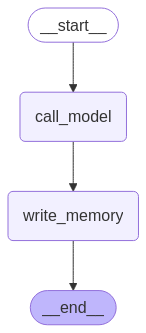

In [25]:
# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [26]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi Lance! It's great to meet you. How can I assist you today?


In [27]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a lot of fun! San Francisco has some beautiful routes for biking. Do you have a favorite trail or area you like to explore?


In [28]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '1'], 'key': '6ba426b7-ba17-4cbb-8785-1450c0da39d9', 'value': {'content': 'User likes to bike around San Francisco.'}, 'created_at': '2025-03-19T16:29:45.679757+00:00', 'updated_at': '2025-03-19T16:29:45.679757+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': '20f534d2-5ed8-4fff-8251-387a1ac8821e', 'value': {'content': 'User likes to bike around San Francisco.'}, 'created_at': '2025-03-19T16:29:45.679757+00:00', 'updated_at': '2025-03-19T16:29:45.679757+00:00', 'score': None}


In [29]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Biking and bakeries make a great combination! Do you have a favorite bakery in San Francisco, or are you on the lookout for new ones to try?


In [30]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries do you recommend for me?
================================== Ai Message ==================================

San Francisco has some fantastic bakeries! Here are a few you might enjoy:

1. **Tartine Bakery** - Known for its delicious bread and pastries, it's a must-visit.
2. **B. Patisserie** - Offers a delightful selection of French pastries, including their famous kouign-amann.
3. **Arizmendi Bakery** - A worker-owned cooperative with great sourdough and pizza.
4. **Craftsman and Wolves** - Known for their inventive pastries and the "Rebel Within," a savory muffin with a soft-cooked egg inside.
5. **Mr. Holmes Bakehouse** - Famous for their cruffins and other creative pastries.

Since you like biking, you could plan a route that takes you to a couple of these spots!
